# Waste Classification - Model Demonstration
## Computer Vision Project Presentation

This notebook demonstrates:
1. Loading trained models
2. Running inference on test data
3. Displaying accuracy metrics and sample predictions

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Class names
class_names = ['aluminium', 'paper', 'plastic']

Using device: cuda


## 2. Model Selection

Based on our experiments, here are the top-performing models:
- **ConvNeXt-Tiny (Raw)**: 76.36% accuracy
- **ResNet50 (Raw)**: 73.35% accuracy
- **ViT-B16 (Raw)**: 72.42% accuracy
- **MobileNetV3-Large (Raw)**: 72.23% accuracy
- **EfficientNetB2 (Raw)**: 71.67% accuracy

In [2]:
# Select which model to demonstrate
# Options: 'convnext', 'resnet50', 'vit', 'mobilenet', 'efficientnet'
MODEL_CHOICE = 'convnext'  # Change this to demo different models

model_configs = {
    'convnext': {
        'name': 'ConvNeXt-Tiny',
        'path': './ConvNeXt-Tiny/models/convnext_tiny_raw.pth',
        'accuracy': 76.36
    },
    'resnet50': {
        'name': 'ResNet50',
        'path': './ResNet50/resnet50_waste_clf_raw.pth',
        'accuracy': 73.35
    },
    'vit': {
        'name': 'ViT-B16',
        'path': './ViT-B16/models/vit_b16_raw.pth',
        'accuracy': 72.42
    },
    'mobilenet': {
        'name': 'MobileNetV3-Large',
        'path': './MobileNetV3-Large/models/mobilenetv3large_raw.keras',
        'accuracy': 72.23
    },
    'efficientnet': {
        'name': 'EfficientNetB2',
        'path': './EfficientNetB2/models/efficientnetb2_raw.keras',
        'accuracy': 71.67
    }
}

selected_config = model_configs[MODEL_CHOICE]
print(f"Selected Model: {selected_config['name']}")
print(f"Expected Accuracy: {selected_config['accuracy']}%")

Selected Model: ConvNeXt-Tiny
Expected Accuracy: 76.36%


## 3. Load Trained Model

In [3]:
def load_convnext_model(model_path):
    """Load ConvNeXt-Tiny model"""
    model = models.convnext_tiny(weights=None)
    
    # Get the number of input features for the classifier
    num_features = model.classifier[2].in_features
    
    # Replace classifier with custom head (must match training architecture)
    model.classifier = nn.Sequential(
        nn.Flatten(1),
        nn.LayerNorm(num_features, eps=1e-6),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 3)
    )
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def load_resnet50_model(model_path):
    """Load ResNet50 model"""
    model = models.resnet50(weights=None)
    
    # Get the number of input features
    num_features = model.fc.in_features
    
    # Replace fc with custom head (must match training architecture)
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 3)
    )
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def load_vit_model(model_path):
    """Load Vision Transformer model"""
    model = models.vit_b_16(weights=None)
    
    # Get the number of input features for the classifier
    num_features = model.heads.head.in_features
    
    # Replace classifier with custom head (must match training architecture)
    model.heads.head = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 3)
    )
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# Load the selected model
if MODEL_CHOICE == 'convnext':
    model = load_convnext_model(selected_config['path'])
elif MODEL_CHOICE == 'resnet50':
    model = load_resnet50_model(selected_config['path'])
elif MODEL_CHOICE == 'vit':
    model = load_vit_model(selected_config['path'])
elif MODEL_CHOICE in ['mobilenet', 'efficientnet']:
    # For Keras models, use TensorFlow/Keras
    import tensorflow as tf
    model = tf.keras.models.load_model(selected_config['path'])
    print("Keras model loaded successfully!")
else:
    raise ValueError(f"Unknown model choice: {MODEL_CHOICE}")

print(f"\n✓ Model loaded successfully from {selected_config['path']}")


✓ Model loaded successfully from ./ConvNeXt-Tiny/models/convnext_tiny_raw.pth


## 4. Prepare Test Data

In [4]:
# Data transforms (matching training setup)
if MODEL_CHOICE in ['convnext', 'resnet50', 'vit']:
    # PyTorch models - using raw dataset
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load test dataset
    test_dataset = ImageFolder('./Dataset/SelfCollected_Dataset', transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"Test dataset size: {len(test_dataset)} images")
    print(f"Classes: {test_dataset.classes}")
else:
    # Keras models - using raw dataset with TensorFlow
    import tensorflow as tf
    
    # Use model-specific preprocessing
    if MODEL_CHOICE == 'mobilenet':
        from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
    elif MODEL_CHOICE == 'efficientnet':
        from tensorflow.keras.applications.efficientnet import preprocess_input
    
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        './Dataset/SelfCollected_Dataset',
        image_size=(224, 224),
        batch_size=32,
        shuffle=False,
        label_mode='categorical'
    )
    
    # Apply model-specific preprocessing (scales to [-1, 1] for both models)
    test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))
    
    print(f"Test dataset loaded with {MODEL_CHOICE} preprocessing")
    print(f"Classes: {class_names}")

Test dataset size: 533 images
Classes: ['aluminium', 'paper', 'plastic']


## 5. Run Inference and Calculate Metrics

In [5]:
if MODEL_CHOICE in ['convnext', 'resnet50', 'vit']:
    # PyTorch inference
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Running inference...")
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
else:
    # Keras inference
    print("Running inference...")
    predictions = model.predict(test_dataset)
    all_preds = np.argmax(predictions, axis=1)
    all_probs = predictions
    
    # Get true labels
    all_labels = []
    for _, labels in test_dataset:
        all_labels.extend(np.argmax(labels.numpy(), axis=1))
    all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n" + "="*50)
print(f"MODEL: {selected_config['name']}")
print("="*50)
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")
print("="*50)

Running inference...

MODEL: ConvNeXt-Tiny
Accuracy:  76.36%
Precision: 77.19%
Recall:    76.36%
F1-Score:  76.47%


## 6. Visualize Results - Confusion Matrix

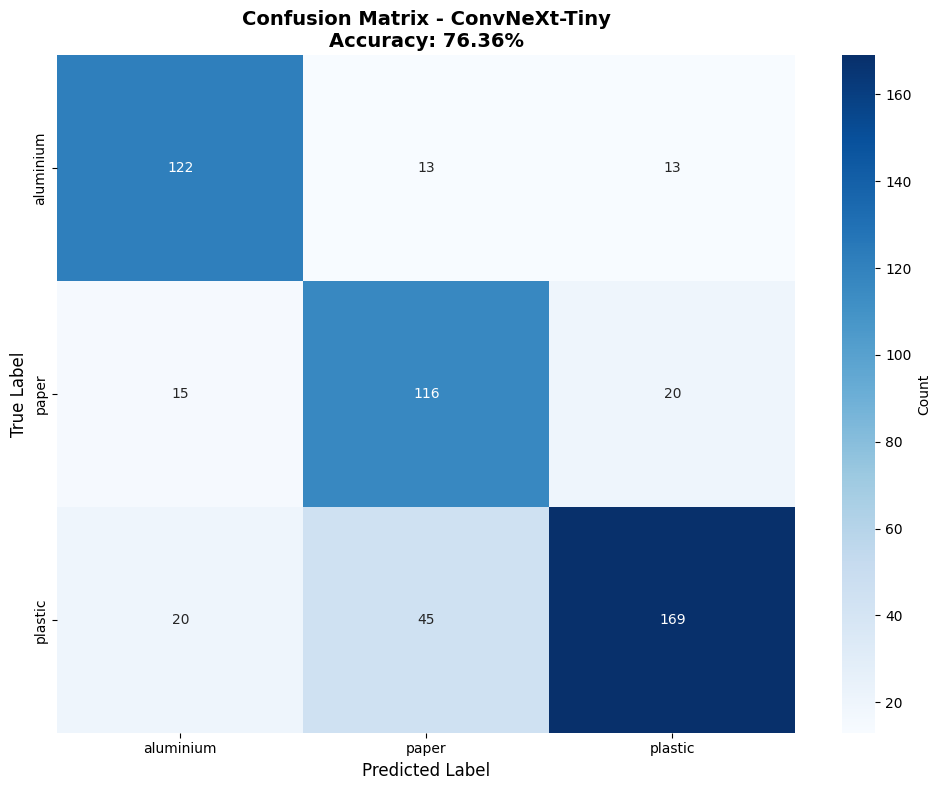


Per-Class Accuracy:
  Aluminium: 82.43%
  Paper: 76.82%
  Plastic: 72.22%


In [6]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {selected_config["name"]}\nAccuracy: {accuracy*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() * 100
    print(f"  {class_name.capitalize()}: {class_acc:.2f}%")

## 7. Sample Predictions Visualization

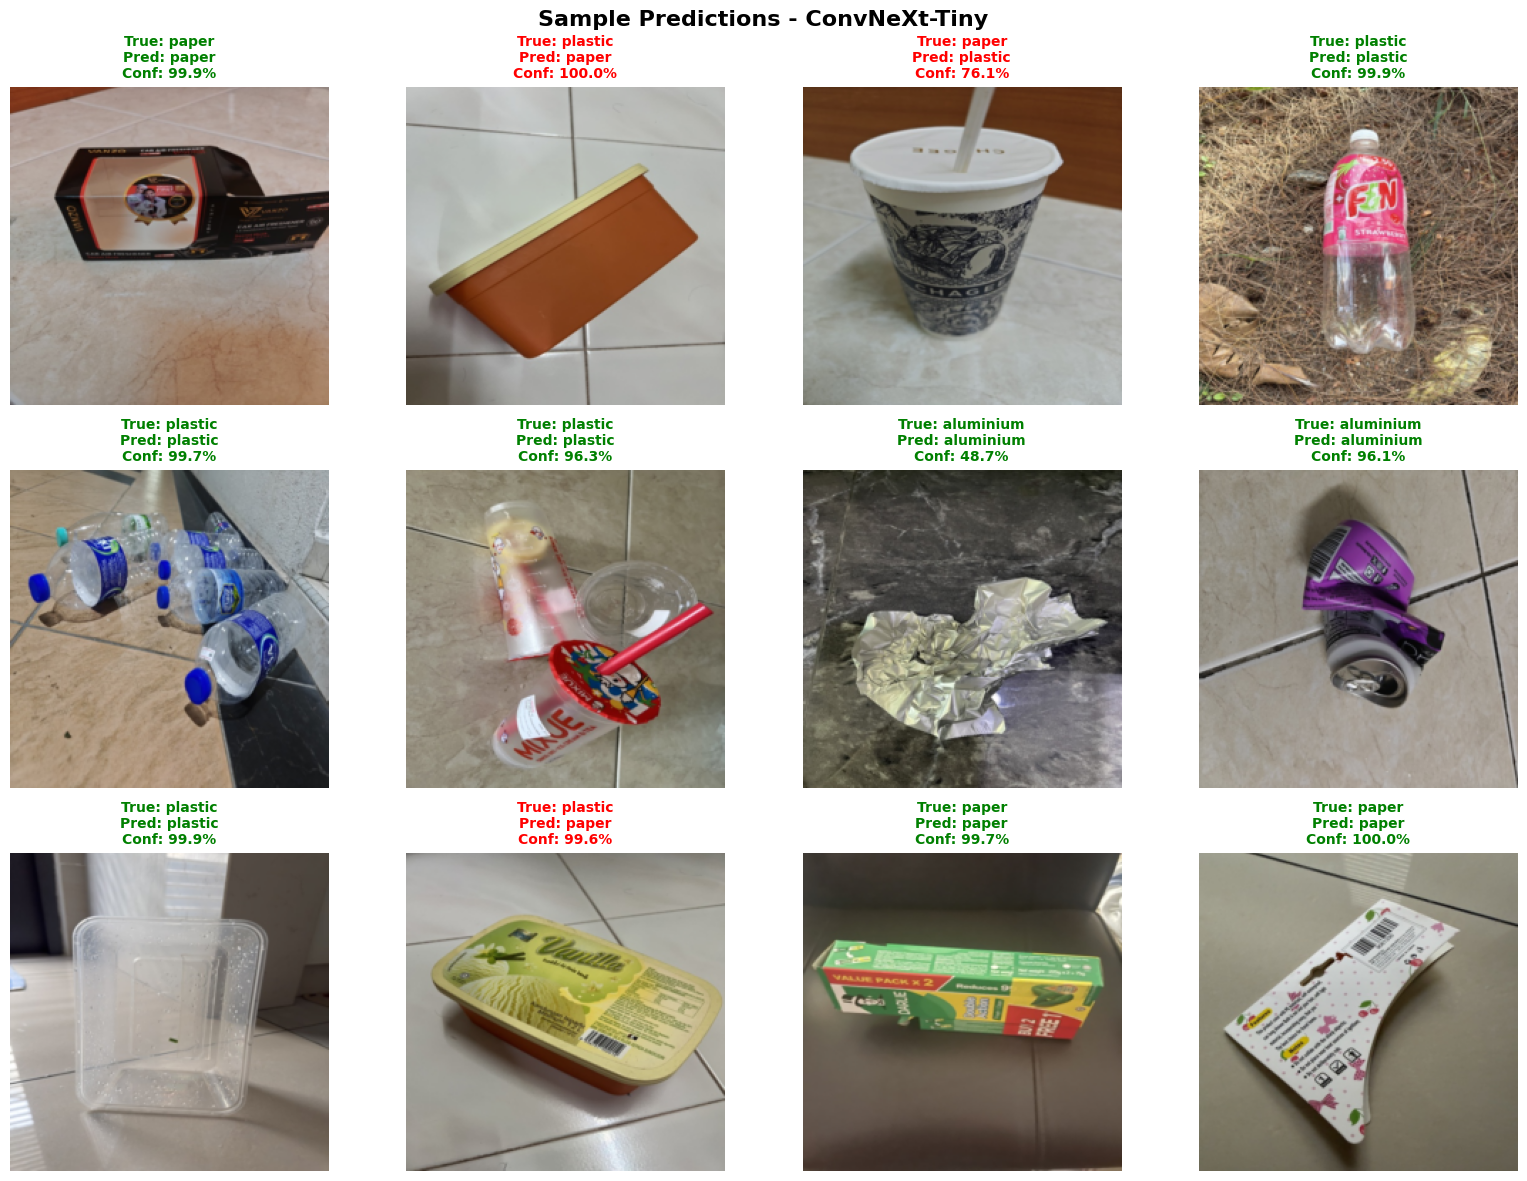

In [7]:
# Show sample predictions
def show_sample_predictions(num_samples=12):
    """Display sample predictions with images"""
    
    if MODEL_CHOICE in ['convnext', 'resnet50', 'vit']:
        # Get random samples from test dataset
        indices = np.random.choice(len(test_dataset), num_samples, replace=False)
        
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.ravel()
        
        for idx, sample_idx in enumerate(indices):
            img, label = test_dataset[sample_idx]
            
            # Get prediction
            with torch.no_grad():
                img_batch = img.unsqueeze(0).to(device)
                output = model(img_batch)
                probs = torch.softmax(output, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                confidence = probs[0, pred_class].item()
            
            # Denormalize image for display
            img_display = img.permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            # Plot
            axes[idx].imshow(img_display)
            axes[idx].axis('off')
            
            true_label = class_names[label]
            pred_label = class_names[pred_class]
            
            color = 'green' if label == pred_class else 'red'
            axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence*100:.1f}%',
                               color=color, fontweight='bold', fontsize=10)
    else:
        # Keras version
        import tensorflow as tf
        
        # Load raw images for display
        raw_dataset = tf.keras.utils.image_dataset_from_directory(
            './Dataset/Public_dataset',
            image_size=(224, 224),
            batch_size=32,
            shuffle=False
        )
        
        # Get first batch
        for images, labels in raw_dataset.take(1):
            images_np = images.numpy()[:num_samples]
            labels_np = labels.numpy()[:num_samples]
            
            # Predict
            preds = model.predict(images)
            
            fig, axes = plt.subplots(3, 4, figsize=(16, 12))
            axes = axes.ravel()
            
            for idx in range(num_samples):
                img = images_np[idx].astype('uint8')
                true_label = class_names[labels_np[idx]]
                pred_class = np.argmax(preds[idx])
                pred_label = class_names[pred_class]
                confidence = preds[idx][pred_class]
                
                axes[idx].imshow(img)
                axes[idx].axis('off')
                
                color = 'green' if labels_np[idx] == pred_class else 'red'
                axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence*100:.1f}%',
                                   color=color, fontweight='bold', fontsize=10)
            break
    
    plt.suptitle(f'Sample Predictions - {selected_config["name"]}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

show_sample_predictions(12)

## 8. Model Comparison Summary


TOP 5 MODELS - RAW DATASET
Rank   Model                Accuracy     F1-Score     Loss      
----------------------------------------------------------------------
1      ConvNeXt-Tiny         76.36%      76.47%     0.7135
2      Resnet50              73.35%      73.62%     0.8459
3      ViT-B16               72.42%      72.19%     1.1055
4      MobileNetV3-Large     72.23%      71.93%     0.9189
5      EfficientNetB2        71.67%      71.67%     0.8575


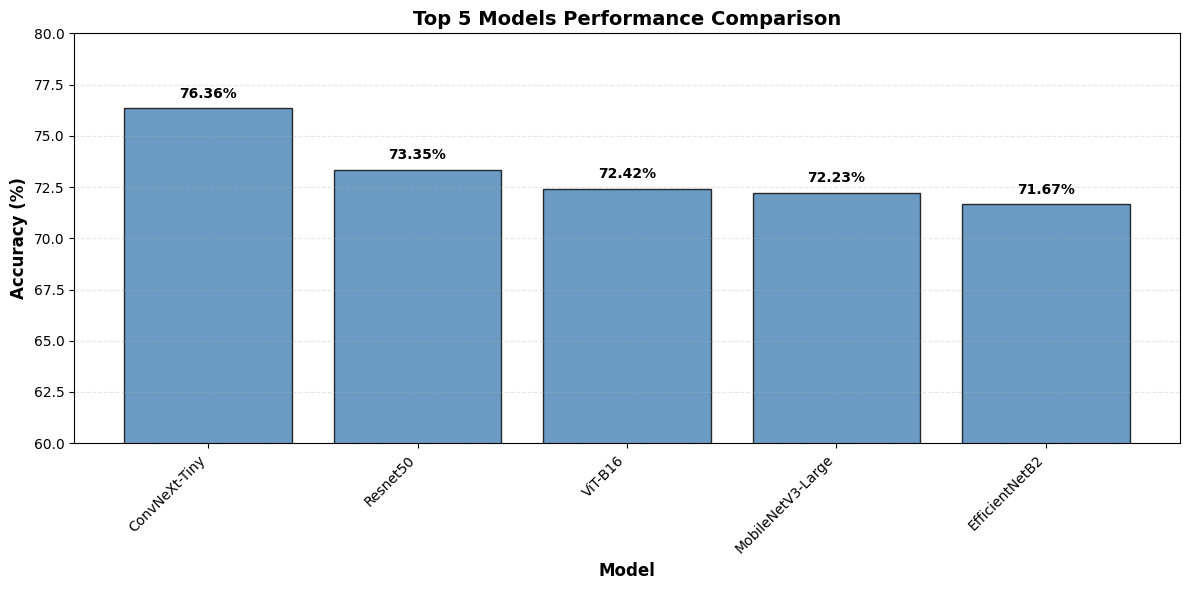

In [8]:
# Load and display summary results
import pandas as pd

summary_df = pd.read_csv('./Analysis/summary_report.csv')

# Filter for raw experiments (best performing)
raw_results = summary_df[summary_df['experiment_type'] == 'Raw'].copy()
raw_results = raw_results.sort_values('accuracy', ascending=False)

# Display top models
print("\n" + "="*70)
print("TOP 5 MODELS - RAW DATASET")
print("="*70)
print(f"{'Rank':<6} {'Model':<20} {'Accuracy':<12} {'F1-Score':<12} {'Loss':<10}")
print("-"*70)

for idx, (_, row) in enumerate(raw_results.head().iterrows(), 1):
    print(f"{idx:<6} {row['model_name']:<20} {row['accuracy']*100:>6.2f}%     "
          f"{row['f1']*100:>6.2f}%     {row['loss']:>6.4f}")

print("="*70)

# Visualize comparison
plt.figure(figsize=(12, 6))
top_models = raw_results.head()
x_pos = np.arange(len(top_models))

plt.bar(x_pos, top_models['accuracy']*100, alpha=0.8, color='steelblue', edgecolor='black')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Top 5 Models Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x_pos, top_models['model_name'], rotation=45, ha='right')
plt.ylim(60, 80)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, v in enumerate(top_models['accuracy']*100):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()